# Exploration of Quantum Algorithm to Solve Traveling Salesman Problem
## By Maxwell Pickard

# Background
**The following section, including images, is either directly taken or paraphrased from the original paper:**: https://arxiv.org/pdf/1805.10928.pdf  
All credit goes to the authors. 

### Traveling Salesman Problem
The goal of the traveling salesman problem involves a salesman who has to travel to $N$ cities, visitng each city only once and ending up where he began his journey. This cycle is known as a Hamiltonian cycle, which is a closed loop through a graph that visits each node once. In this case, the nodes are the cities and the loop is the journey the salesman takes.  
Each city (node) is connected to one another by a route (edge) with an associated cost, where the cost is a measure of the diffculty to take the associated edge. The goal of the traveling salesman problem is to minimize the cost while satisfying the above conditions; thus, this problem is an optimization problem. Classically, this problem becomes impossible to solve for large $N$, becasue $(N-1)!$ iterations are needed to search for the optimal solution. Breaking up the problem into smaller components does not lower the complexity of the problem, meaning this problem belongs to the class of NP hard problems

### The Quantization of the Traveling Salesman
There have been many proposed solutions to the problem via quantum computing and algorithms.  The following solution was created by a group of researchers from the Indian Institute of Technology and the Indian Institute of Science Education and Research. The idea is to encoded the costs of traveling between cities as phases and then constructing unitary operators with eigenvectors whose computational basis states and eigenvalues are various combinations of the phases. Then, by applying a phase estimation algorithm to certain eigenstates which returns the alll the total possible costs for all possible routes. Once this information is found, then Durr and Hoyer's quantum algorithm for finding the minimum is used to find the route with the smallest cost.
  
Algorithm Steps:

1. Encoding the costs:  
    Input a matrix $B$ such that $[b]_{ij}= e^{i\phi_{ij}}$, where $\phi_{ij}$ is the cost of traveling from city $i$ to city $j$.  
    
2. Construct Unitaries $U_j$ from Matrix B:
    $$ [U_j]_{kk} = \frac{1}{\sqrt{N}}[B]_{jk} $$ where $N$ is the number of cities and $j,k > 0$ and $j,k\in[1,N]$. U is a unitary diagonal matrix, with all other elements being 0.

3. Use the constructed $U_j$ matrices to create a main Unitary Matrix $U$:
    $$U=U_1\otimes U_2\otimes...\otimes U_N$$ where U is the tensor product of all the unitaries.
    
4. Estimate the eigenvalues of of $U$ using the phase estimation algorithm:  
    The phases can then be normalized to between 0 and $2pi$ given the range of distances between cities  
    Since $U$ is a diagonal matrix, its eigenstates are computational basis states with eigenvalues as the corresponding diagonal elements, thus there will be $(N-1)!$ elements of interest out of $N^N$ elements.  
    Thus, there are $(N-1)!$ eigenstates of $U$ with the eigenvalues being the total cost of the corresponding Hamiltonian cycle as phase.
5. Get phases and find minimum:  
    The phases are given in the form of a binary output from the phase estimation algorithm, and then the Durr and Hoyer quantum alogirthm for finding the minimum is applied to get the minimum cost and the corresponding route.

### Things to Note
In the following example where we estimate the phase of a certain eigenstate, we would need to do the same algorithm 6 times to get estimates of the phase for each possible eigenstate, and then once we have them, we would need to perform the quantum algorithm to find the minimum.  
  
In the example, the eigenstate represents the route going through the cities 1,2,3, and 4 in the same order and returning to 1. If one were to start in any other city but follow the same route (i.e. 2, 3, 4, 1 in order returning to 2) they would have the same eigenstate. You can find the eigenstate for any route as follows:  
  
Given a route, if we go from city $i$ to city $j$, then each $i$ is *uniquely* mapped to $j$. Thus, $i$ can be written as a function of $j$: $i(j)$  
The corresponding eigenstate to that route is given by: $$ |\psi \rangle=\underset{j}{\otimes}|i(j)-1\rangle $$ where j goes from $1$ to $n$

### Problems with this Algorithm

### Example:
Using 4 cities with the following distances:

$\phi_{12} = \phi_{12} = \frac{\pi}{2}$  
$\phi_{13} = \phi_{13} = \frac{\pi}{8}$  
$\phi_{14} = \phi_{14} = \frac{\pi}{4}$  
$\phi_{23} = \phi_{32} = \frac{\pi}{4}$  
$\phi_{24} = \phi_{42} = \frac{\pi}{4}$  
$\phi_{34} = \phi_{43} = \frac{\pi}{8}$

Perform the phase estimation of the eigenstate |11000110> corresponding to the Hamiltonian Cycle: 1 > 2 > 3 > 4 > 1

### Dependencies

In [584]:
#initialization
from IPython.display import Image
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import math

# importing Qiskit
from qiskit import IBMQ, BasicAer
from qiskit.providers.ibmq import least_busy
from qiskit import QuantumCircuit, ClassicalRegister, QuantumRegister, execute

# import basic plot tools
from qiskit.tools.visualization import plot_histogram

### Construct Unitaries Function
To perform phase estimation, we need the controlled tensor product of the unitaries
$$Controlled(U) == Controlled(U_1\otimes U_2\otimes U_3\otimes U_4) == (C- U_1\otimes C-U_2\otimes C-U_3\otimes C-U_4)$$
where $C-U_j$ is the controlled $U_j$. To get $C-U_j$, we can use the decomposition of $U_j$ and implement controlled each element in the decomposition
#### Decomposition of Unitary $j$
<img src='images/unitaryDecomp.png' style="width: 800px"/>  

#### Controlled $U_J$ Gate
<img src='images/cUjGate.png' style="width: 400px"/>

In [2]:
def controlled_U(circ,a,b,c,d,n,k):
    circ.cp(c-a, q[n_ancilla-k], q[n_ancilla+n]) # Controlled U-Gate
    circ.p(a,q[n_ancilla-k]) # 
    circ.cp(b-a, q[n_ancilla-k], q[n_ancilla+n+1])
    circ.ccx(q[n_ancilla-k], q[n_ancilla+n], q[n_ancilla+n+1])
    circ.p(d+c-b-a,q[n_ancilla+n+1])
    circ.ccx(q[n_ancilla-k], q[n_ancilla+n], q[n_ancilla+n+1])

### Inverse Quantum Fourier Transform
Transforms from X-Basis States to Z-Basis States

In [3]:
def qft_dagger(circ, q, n):
    """n-qubit QFTdagger on q in circ."""
    for j in range(n):
        k = (n-1) - j
        for m in range(k):
            circ.cp(-math.pi/float(2**(k-m)), q[k], q[m])
        circ.h(q[k])

### Setup Quantum Circuit

#### Our Quantum Circuit
<img src='images/circuit.jpg' style="width: 400px"/>

In our quantum circuit, we have 14 qubits, 6 of which are dedicated to estimating the phase and the other 8 for preparing the corresponding eigenstate by using Pauli-X gates on certain qubits. All the qubits are initalized to the $|0\rangle$ state. The part in red represents this initalization of the eigenstate, and the part in blue performs the phase estimation. You will notice in the red section containing the 8 qubits used for creating the eigenstate, that the Pauli-X gates are on the indices 0,1,5,and 6. This corresponds to the eigenstate $|11000110\rangle$

In [4]:
n_ancilla = 6 # number of qubits for estimating phase (num of possible paths)
n_eigenvector = 8 #number of qubits for preparing the corresponding eigenstate to test (4 nodes encoded)

q = QuantumRegister(n_ancilla+n_eigenvector, 'q') # 14 qubits
c = ClassicalRegister(n_ancilla, 'c') # 6 classical bits

qpe = QuantumCircuit(q, c) # Create Quantum Circuit

# Initialize the Eigenstate
# Flip qubits 1,2 6,7 to State1 corresponding to phase estimation of eigenstate |11000110>
# |11000110> ==> Hamiltonian Cycle 1 -> 2 -> 3 -> 4 -> 1
qpe.x(q[n_ancilla])
qpe.x(q[n_ancilla+1])
qpe.x(q[n_ancilla+5])
qpe.x(q[n_ancilla+6])

# Hadamard gate on first n_ancilla qubits
for i in range(n_ancilla):
    qpe.h(q[i])
qpe.barrier()

### Construct Unitaries and Phase Estimation

In [5]:
for i in range(1): # Not necessary but added for simplicity
    controlled_U(qpe,0,math.pi/2,math.pi/8,math.pi/4,0,1) # C-U1
    controlled_U(qpe,math.pi/2,0,math.pi/4,math.pi/4,2,1) # C-U2
    controlled_U(qpe,math.pi/8,math.pi/4,0,math.pi/8,4,1) # C-U3
    controlled_U(qpe,math.pi/4,math.pi/4,math.pi/8,0,6,1) # C-U4
    qpe.barrier()

for i in range(2): #2^k-1 == 2^1 == 2
    controlled_U(qpe,0,math.pi/2,math.pi/8,math.pi/4,0,2)
    controlled_U(qpe,math.pi/2,0,math.pi/4,math.pi/4,2,2)
    controlled_U(qpe,math.pi/8,math.pi/4,0,math.pi/8,4,2)
    controlled_U(qpe,math.pi/4,math.pi/4,math.pi/8,0,6,2)
qpe.barrier()

for i in range(4):
    controlled_U(qpe,0,math.pi/2,math.pi/8,math.pi/4,0,3)
    controlled_U(qpe,math.pi/2,0,math.pi/4,math.pi/4,2,3)
    controlled_U(qpe,math.pi/8,math.pi/4,0,math.pi/8,4,3)
    controlled_U(qpe,math.pi/4,math.pi/4,math.pi/8,0,6,3)
qpe.barrier()
for i in range(8):
    controlled_U(qpe,0,math.pi/2,math.pi/8,math.pi/4,0,4)
    controlled_U(qpe,math.pi/2,0,math.pi/4,math.pi/4,2,4)
    controlled_U(qpe,math.pi/8,math.pi/4,0,math.pi/8,4,4)
    controlled_U(qpe,math.pi/4,math.pi/4,math.pi/8,0,6,4)
qpe.barrier()
for i in range(16):
    controlled_U(qpe,0,math.pi/2,math.pi/8,math.pi/4,0,5)
    controlled_U(qpe,math.pi/2,0,math.pi/4,math.pi/4,2,5)
    controlled_U(qpe,math.pi/8,math.pi/4,0,math.pi/8,4,5)
    controlled_U(qpe,math.pi/4,math.pi/4,math.pi/8,0,6,5)
qpe.barrier()
for i in range(32): 
    controlled_U(qpe,0,math.pi/2,math.pi/8,math.pi/4,0,6)
    controlled_U(qpe,math.pi/2,0,math.pi/4,math.pi/4,2,6)
    controlled_U(qpe,math.pi/8,math.pi/4,0,math.pi/8,4,6)
    controlled_U(qpe,math.pi/4,math.pi/4,math.pi/8,0,6,6)
qpe.barrier()

### Quantum Fourier Transform 

In [6]:
qft_dagger(qpe,q,6)
qpe.barrier()
for i in range(n_ancilla):
    qpe.measure(q[i],c[i])

### Measure Phase Estimates
Note that this runs the circuit on a **simulated** quantum computer. The *qasm_simulator* simulates a perfect quantum computer, but is not truly quantum. It is important to note the difference as a real quantum computer will have quantum error

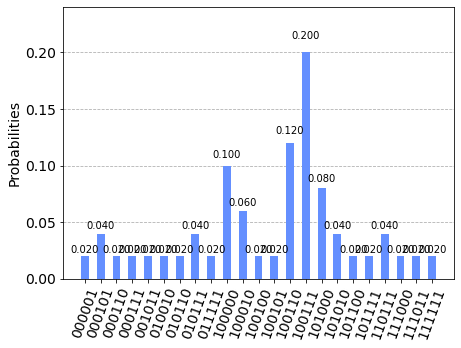

In [7]:
backend = BasicAer.get_backend('qasm_simulator')
shots = 50
results = execute(qpe, backend=backend, shots=shots).result()
answer = results.get_counts()
plot_histogram(answer)

In [8]:
answer.most_frequent()

'100111'

# Applying the Algorithm to Real Cities
In the paper, the researchers use 4 different cities and normalize the costs between 0 and $2pi$. We will be doing the same (for some practical reasons). But, we will be applying this algorithm to real world data. For this exercise, We will use the following cities: **San Diego, Los Angeles, Palm Springs, Santa Barbara** and **Average Driving Time (ADT)** as our cost. The reason we are using 4 cities like the paper is to allow us to use the same eigenstates (routes) tested and same quantum circuit. But, we will go a step further and test all 6 possible eigenstates, as well as use the Durr and Hoyer algorithm. The four cities were chosen because I live in San Diego at the time of working on this and I'm genuinely curious what is in theory the fastest route is since I tend to travel close to all these places.

### Setup
From the paper, we already know what our eigenstates are going to be, eliminating the need to calculate them for this exercise:

#### Cities
We will denote the following:  
&nbsp;San Diego: City 1  
&nbsp;Los Angeles: City 2  
&nbsp;Palm Springs: City 3  
&nbsp;Santa Barbara: City 4

#### Routes and Eigenstates
&nbsp;**Route 1**: 1 &rarr; 2 &rarr; 3 &rarr; 4 &rarr; 1 ($|11000110\rangle$)  
&nbsp;**Route 2**: 3 &rarr; 4 &rarr; 1 &rarr; 2 &rarr; 3 ($|01101100\rangle$)   
&nbsp;**Route 3**: 4 &rarr; 1 &rarr; 3 &rarr; 2 &rarr; 4 ($|10001101\rangle$)  
&nbsp;**Route 4**: 1 &rarr; 4 &rarr; 2 &rarr; 3 &rarr; 1 ($|01110010\rangle$)   
&nbsp;**Route 5**: 4 &rarr; 2 &rarr; 1 &rarr; 3 &rarr; 4 ($|11100001\rangle$)  
&nbsp;**Route 6**: 3 &rarr; 1 &rarr; 2 &rarr; 4 &rarr; 3 ($|10110100\rangle$)  


#### Path Binary Mapping
$10$: &rarr; 1  
$11$: &rarr; 2  
$00$: &rarr; 3  
$01$: &rarr; 4  

 ### Normalizing Travel Time Data and Inputs Matrix 
 First, we take the average travel time and normalize the data to between 0 and $2\pi$, then using that data we create a modified cost matrix $C$, where instead of $1$s along the diagonal we have $0$s. Since the *controlled_U()* function uses the normalized distances as arguments, we do not have to convert the cost matrix to represent phases. For this exercise, we will assume **symmetry**, i.e. the average drive time from San Diego to Palm Springs is exactly the same as the drive from Palm Springs to San Diego ($\phi_{13} == \phi_{31}$). Thus, we only need to find 6 values. For this exercise we will also write the average drive times in terms of minutes. To get the average times, we use the following link: https://www.travelmath.com/driving-time/from/San+Diego,+CA/to/Los+Angeles,+CA

In [583]:
import numpy as np

# normalize costs between a and b
def norm(x, r, minx, a, b):
    normed = a + ((x-minx)*(b-a))/r
    return(normed)

In [10]:
# Average Drive Times in minutes
phi12 = 117
phi13 = 130
phi14 = 207
phi23 = 101
phi24 = 98
phi34 = 193

# Put Costs into List
costs = [phi12, phi13, phi14, phi23, phi24, phi34]
r = max(costs)-min(costs)

# Normalize Costs
norm_costs = []
for i in costs:
    cost = norm(i, r, min(costs), 0, (2*np.pi))
    norm_costs.append(cost)

# Cost Matrix
C_mat = np.zeros((4,4))
C_mat[0][1] = norm_costs[0] 
C_mat[0][2] = norm_costs[1] 
C_mat[0][3] = norm_costs[2] 
C_mat[1][2] = norm_costs[3] 
C_mat[1][3] = norm_costs[4] 
C_mat[2][3] = norm_costs[5] 
C_mat[1][0] = norm_costs[0] 
C_mat[2][0] = norm_costs[1] 
C_mat[3][0] = norm_costs[2] 
C_mat[2][1] = norm_costs[3] 
C_mat[3][1] = norm_costs[4] 
C_mat[3][2] = norm_costs[5] 

C_mat

array([[0.        , 1.09523414, 1.84460486, 6.28318531],
       [1.09523414, 0.        , 0.17293171, 0.        ],
       [1.84460486, 0.17293171, 0.        , 5.47617068],
       [6.28318531, 0.        , 5.47617068, 0.        ]])

### Algorithm
We will use the same functions for the earlier example: *controlled_U()* and *qft_dagger()*, but we create new functions to run the phase estimation by passing in our modified cost matrix and the indexes of the 4 qubits to flip

In [11]:
# Function to create Quantum circuit with the indexes of qubits that need to be flipped as arguments
def create_circuit(indexes, i):
    n_ancilla = 6 # number of qubits for estimating phase (num of possible paths)
    n_eigenvector = 8 #number of qubits for preparing the corresponding eigenstate to test (4 nodes encoded)
    
    q = QuantumRegister(n_ancilla+n_eigenvector, 'q') # 14 qubits
    c = ClassicalRegister(n_ancilla, 'c') # 6 classical bits
    
    qpe = QuantumCircuit(q, c) # Create Quantum Circuit

    # Initialize the Eigenstate
    # Flip qubits 1,2 6,7 to State1 
    # a,b,c,d refer to the qubit index to flip (i.e. a = 0 flips the first qubit state)
    qpe.x(q[n_ancilla+indexes[i][0]])
    qpe.x(q[n_ancilla+indexes[i][1]])
    qpe.x(q[n_ancilla+indexes[i][2]])
    qpe.x(q[n_ancilla+indexes[i][3]])

    # Hadamard gate on first n_ancilla qubits
    for i in range(n_ancilla):
        qpe.h(q[i])
    qpe.barrier()
    
    return(qpe)

In [12]:
def phase_estimation(C, indexes, i, back = BasicAer.get_backend('qasm_simulator')):
    
    qpe = create_circuit(indexes, i)
    
    for i in range(1): # Not necessary but added for simplicity
        controlled_U(qpe,C[0][0],C[0][1],C[0][2],C[0][3],0,1) # C-U1
        controlled_U(qpe,C[1][0],C[1][1],C[1][2],C[1][3],2,1) # C-U2
        controlled_U(qpe,C[2][0],C[2][1],C[2][2],C[2][3],4,1) # C-U3
        controlled_U(qpe,C[3][0],C[3][1],C[3][2],C[3][3],6,1) # C-U4
        qpe.barrier()
    for i in range(2): 
        controlled_U(qpe,C[0][0],C[0][1],C[0][2],C[0][3],0,2) # C-U1
        controlled_U(qpe,C[1][0],C[1][1],C[1][2],C[1][3],2,2) # C-U2
        controlled_U(qpe,C[2][0],C[2][1],C[2][2],C[2][3],4,2) # C-U3
        controlled_U(qpe,C[3][0],C[3][1],C[3][2],C[3][3],6,2) # C-U4
        qpe.barrier()
    for i in range(4): # Not necessary but added for simplicity
        controlled_U(qpe,C[0][0],C[0][1],C[0][2],C[0][3],0,3) # C-U1
        controlled_U(qpe,C[1][0],C[1][1],C[1][2],C[1][3],2,3) # C-U2
        controlled_U(qpe,C[2][0],C[2][1],C[2][2],C[2][3],4,3) # C-U3
        controlled_U(qpe,C[3][0],C[3][1],C[3][2],C[3][3],6,3) # C-U4
        qpe.barrier()
    for i in range(8): 
        controlled_U(qpe,C[0][0],C[0][1],C[0][2],C[0][3],0,4) # C-U1
        controlled_U(qpe,C[1][0],C[1][1],C[1][2],C[1][3],2,4) # C-U2
        controlled_U(qpe,C[2][0],C[2][1],C[2][2],C[2][3],4,4) # C-U3
        controlled_U(qpe,C[3][0],C[3][1],C[3][2],C[3][3],6,4) # C-U4
        qpe.barrier()
    for i in range(16): # Not necessary but added for simplicity
        controlled_U(qpe,C[0][0],C[0][1],C[0][2],C[0][3],0,5) # C-U1
        controlled_U(qpe,C[1][0],C[1][1],C[1][2],C[1][3],2,5) # C-U2
        controlled_U(qpe,C[2][0],C[2][1],C[2][2],C[2][3],4,5) # C-U3
        controlled_U(qpe,C[3][0],C[3][1],C[3][2],C[3][3],6,5) # C-U4
        qpe.barrier()
    for i in range(32): 
        controlled_U(qpe,C[0][0],C[0][1],C[0][2],C[0][3],0,6) # C-U1
        controlled_U(qpe,C[1][0],C[1][1],C[1][2],C[1][3],2,6) # C-U2
        controlled_U(qpe,C[2][0],C[2][1],C[2][2],C[2][3],4,6) # C-U3
        controlled_U(qpe,C[3][0],C[3][1],C[3][2],C[3][3],6,6) # C-U4
        qpe.barrier()
        
    qft_dagger(qpe,q,6)
    qpe.barrier()
    for i in range(n_ancilla):
        qpe.measure(q[i],c[i])
        
    backend = back
    shots = 1000
    results = execute(qpe, backend=backend, shots=shots).result()
    answer = results.get_counts()
    
    mf = answer.most_frequent()
    
    return(mf)

### Phase Estimation
We will need to run the phase estimation 6 times, once for each state. The returned phase will be stored in phases vector after being converted to an integer, with the index of the vector indicating the route:
  
&nbsp;**Route 1**: 1 &rarr; 2 &rarr; 3 &rarr; 4 &rarr; 1 ($|11000110\rangle$)  
&nbsp;**Route 2**: 3 &rarr; 4 &rarr; 1 &rarr; 2 &rarr; 3 ($|01101100\rangle$)   
&nbsp;**Route 3**: 4 &rarr; 1 &rarr; 3 &rarr; 2 &rarr; 4 ($|10001101\rangle$)  
&nbsp;**Route 4**: 1 &rarr; 4 &rarr; 2 &rarr; 3 &rarr; 1 ($|01110010\rangle$)   
&nbsp;**Route 5**: 4 &rarr; 2 &rarr; 1 &rarr; 3 &rarr; 4 ($|11100001\rangle$)  
&nbsp;**Route 6**: 3 &rarr; 1 &rarr; 2 &rarr; 4 &rarr; 3 ($|10110100\rangle$)

In [586]:
i1 = [0,1,5,6] # Route 1
i2 = [1,2,4,5] # Route 2
i3 = [0,4,5,7] # Route 3
i4 = [1,2,3,6] # Route 4
i5 = [0,1,2,7] # Route 5
i6 = [0,2,3,5] # Route 6

index = [i1,i2,i3,i4,i5,i6]

phases = []
# try catch?
for i in range(6):
    try:
        bin_phase = phase_estimation(C_mat, index, i)
        num = int(bin_phase, 2)
        phases.append(num)
    except:
        phases = []
        for i in range(6):
            bin_phase = phase_estimation(C_mat, index, i)
            num = int(bin_phase, 2)
            phases.append(num)
phases

[18, 15, 45, 13, 29, 26, 15, 45, 13, 33, 26]

It is easy to see from the outputted phase vector that the route with the **lowest estimated cost is Route 4** (1 &rarr; 4 &rarr; 2 &rarr; 3 &rarr; 1) or (**San Diego &rarr; Santa Barbara &rarr; Los Angeles &rarr; Palm Springs &rarr; San Diego**) , with an estimated cost of 13 units, but for the case that more than 4 cities are used, we can implement a **Quantum Search Algorithm**

## Durr and Hoyer's Quantum Algorithm for Finding the Minimum 
Algorithm Steps:  
Let $T$ be an unsorted table of $N$ items, each holding a value from an ordered set and assume all values are distinct.
1. Choose threshold index $0\leq y\leq N-1$ uniformly at random.
2. Repeat the following and interupt when run time is greater than $22\sqrt{N}+1.4\log(N)$, then go to 2(c):  
    a. Initailize memory as $\sum_j\frac{1}{\sqrt{N}} |j\rangle|y\rangle$ and mark every item j for which $T[j] < T[y]$  
    b. Appy **Quantum Exponential Searching Algorithm**   
    c. Obsrve the first register, let $y'$ be the outcome. If $T[y'] < T[y]$ then set threshold to index from $y$ to $y'$

#### Quantum Exponential Searching Algorithm
The Quantum Exponential Searching Algorithm (QESM) is a generalization of Grover's Search Algorithm  
Grover's Search Algorithm can be found here:https://en.wikipedia.org/wiki/Grover%27s_algorithm  

##### Setup
Suppose we have a function $f:{0,1,...,N-1}\rightarrow{0,1}$. You can think of the domain as the indices to a database, and $f(x)=1$ if a data point satisfys the search criteria. We assume only one entry $\omega$ satisfys the criteria, and the goal is to find this $\omega$  
We can access $f$ with a subroutine called an *oracle* in the form of a unitary operator $U_\omega$ that does the following:  

$$\begin{equation}
    \begin{cases}
        U_\omega|x\rangle = -|x\rangle, x=\omega\\
        U_\omega|x\rangle = |x\rangle, x\neq\omega
    \end{cases}       
\end{equation} $$

This uses $N$-dimensional state space $\mathcal{H}$ which is supplied by a reigster with $n=[log_2N]$ qubits:
  
$$U_\omega|x\rangle=(-1)^{f(x)}|x\rangle$$  

Grover's algorithm returns $\omega$ with a probability of at least $\frac{1}{2}$ using $O(\sqrt(N))$ applications of $U_\omega$
  
##### Algorithm:  
1. Initialize the system to the uniform superposition for all states  
2. Perform "Grover iteration" $rN$ times: 
    a. Apply $U_\omega$ operator
    b. Apply the *Grover Diffusion* operator $U_s=2|s\rangle\langle s|-I$
3. Measure the resulting Quantum State in the computational basis.  
  
$r$ is the number (integer) of Grover iterations, with the best choice being $\frac{\pi}{4}{N}^\frac{1}{2}$  
In the case of $k$ matching entries,the optimal number of iterations becomes $\frac{\pi}{4}(\frac{N}{k})^\frac{1}{2}$  


For this, we will use the code from https://github.com/sid1993/qbitwise/blob/master/Durr_Hoyer_Modified_Max.ipynb and modify it to return the minimum instead of the maximum.

In [14]:
import random
import math

In [582]:
# Put system in superposition state
def superposition(qubits):
    states = []
    #Hadamard Transformation
    total_states = int(math.pow(2,qubits))
    amplitude = 1/math.sqrt(total_states)
    for _ in range(0,total_states):
        states.append(amplitude)
    return states

In [491]:
def markingOracle(states,datalist,y):
    # marks all states/elements less than datalist[y]
    for index in range(len(datalist)):
        if datalist[index] < datalist[y]:
            states[index] *= -1 #phase inversion
    return states

In [492]:
def grover_diffusion(states):
    average = sum(states)/len(states)
    for i in range(0,len(states)):
        states[i] = (average-states[i]) + average
    return states

In [493]:
def oracle(states,datalist,key):
    for j in range(0, len(datalist)):
        if datalist[j] < key:
            states[j] *= -1 #phase inversion
    return states

In [494]:
def grover_iteration(states,j,y, datalist, qubits):
    num_iterations = j
    for _ in range(0,num_iterations):
        states = oracle(states,datalist,y)
        states = grover_diffusion(states)
    probability_states = [states[i]*states[i] for i in range(0,len(states))] # HUH
    #print(probability_states)
    
    min_value = min(probability_states)
    index_with_min_val = []
    for i in range(len(probability_states)):
        if probability_states[i] == min_value:
            index_with_min_val.append(i)
    if (len(index_with_min_val) > 1):
        # subtract qubits needed avoid the extra 0s
        index_random_state_with_min_val = index_with_min_val[random.randint(0,len(index_with_min_val)-qubits)]
        return index_random_state_with_min_val
    else:
        return(index_with_min_val[0])

In [500]:
def exponential_search(states,datalist,y, qubits):
    m =1
    alpha = 6/5 #(Any value of λ strictly between 1 and 4/3 would do.)
    while True:
        j = random.randint(0,int(m)-1) # number of iterations of Grover
        i = grover_iteration(states,j,y, datalist, qubits)
        #print(datalist[i]," ",datalist[y])
        if datalist[i] > datalist[y]:
            m = min(alpha*m,math.sqrt(len(datalist)))
        else:
            break
    return i

In [501]:
def marked(states):
    for s in states:
        if s<0:
            return True
    return False

In [536]:
def findMinIndex(datalist):
    size_datalist = len(datalist)
    qubits_needed = math.ceil(math.log(size_datalist,2))
    paddings_required = int(math.pow(2,qubits_needed) - size_datalist)
    for _ in range(0,paddings_required):
         datalist.append(0)
    
    y = random.randint(0,len(datalist)-3)
    print("Starting threshold : ",datalist[y])
    print("Exponential search steps :")
    max_iteration = int(22.5 * math.sqrt(len(datalist)) + 1.4 * math.log2(len(datalist)))
    
    for _ in range(0,max_iteration):
        states = superposition(qubits_needed)
        states = markingOracle(states,datalist,y) # marks all states/elements greater than datalist[y]
        if marked(states):
            new_y = exponential_search(states,datalist,y, qubits_needed) # fina an element greater than datalist[y]
            if datalist[new_y] < datalist[y]:
                print(datalist[y]," ---> ",datalist[new_y])
                y = new_y
        else:
            break
    return y

In [580]:
y = findMinIndex(phases)
y

Starting threshold :  45
Exponential search steps :
45  --->  26
26  --->  15
15  --->  13


3

The Quantum Algorithm for finding the minimum returns 3 as the index of the minimum, which is the index associated with Route 4. While it is easy to see that by looking at the values, if you were to add more cities, the number of routes grows considerably, thus making this algorithm necessary.  

# Expanding the Problem